## Changing response functions
*R.A. Collenteur, University of Graz, 2021*

In this notebook the new `ChangeModel` is tested, based on the work by [Obergfjell et al. (2019)](https://ngwa.onlinelibrary.wiley.com/doi/10.1111/gwat.12891). The main idea is to apply different response functions for two different periods. As an example we look at the the groundwater levels measured near the river the Mur in Austria, where a dam was recently built. 



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions(numba=True)

Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.20.0b
Matplotlib version: 3.4.3
numba version: 0.53.1


## 1. Load the data

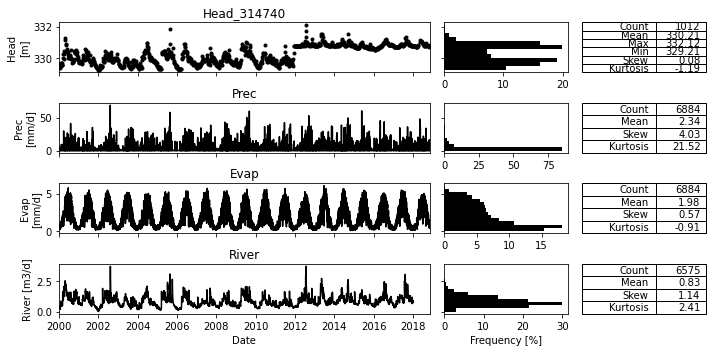

In [11]:
prec = pd.read_csv("data_step/prec.csv", index_col=0, 
                   parse_dates=True, squeeze=True)
evap = pd.read_csv("data_step/evap.csv", index_col=0, 
                   parse_dates=True, squeeze=True)
head = pd.read_csv("data_step/head.csv", index_col=0,
                   parse_dates=True, squeeze=True)
river = pd.read_csv("data_step/river.csv", index_col=0, 
                   parse_dates=True, squeeze=True)
river -= river.min()

axes = ps.plots.series(head=head, stresses=[prec, evap, river], tmin="2000",
                       labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]", "River [m3/d]"])

## 2. The weighting factor

The stress is convoluted two times with different response functions. Then, a weighting function is used to add the two contributions together and compute the final contribution. 

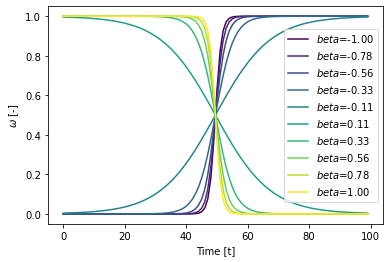

In [12]:
npoints = 100

tchange = 50 / npoints
t = np.linspace(0, 1, npoints)
color = plt.cm.viridis(np.linspace(0, 1, 10))

for beta, c in zip(np.linspace(-1, 1, 10), color):
    beta1 = beta * npoints
    omega = 1 / (np.exp(beta1 * (t - tchange)) + 1)
    plt.plot(omega, color=c, label="$beta$={:.2f}".format(beta))
    
plt.ylabel("$\omega$ [-]")
plt.xlabel("Time [t]")
plt.legend()

## 3. Make a model
We now make two models:

- one model where we assume the response of the heads to the river level remains the same
- and one model where the response to the river levels changes. 


/home/david/Github/pastas/pastas/stressmodels.py:1460: RuntimeWarning: overflow encountered in exp
  omega = 1 / (np.exp(beta * (t - sigma)) + 1)
/home/david/Github/pastas/pastas/stressmodels.py:1460: RuntimeWarning: overflow encountered in exp
  omega = 1 / (np.exp(beta * (t - sigma)) + 1)
/home/david/Github/pastas/pastas/stressmodels.py:1460: RuntimeWarning: overflow encountered in exp
  omega = 1 / (np.exp(beta * (t - sigma)) + 1)
/home/david/Github/pastas/pastas/stressmodels.py:1460: RuntimeWarning: overflow encountered in exp
  omega = 1 / (np.exp(beta * (t - sigma)) + 1)


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['River']"}>,
 <AxesSubplot:title={'right':'Stresses: []'}>,
 <AxesSubplot:title={'center':'Step response'}, xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=8)'}>]

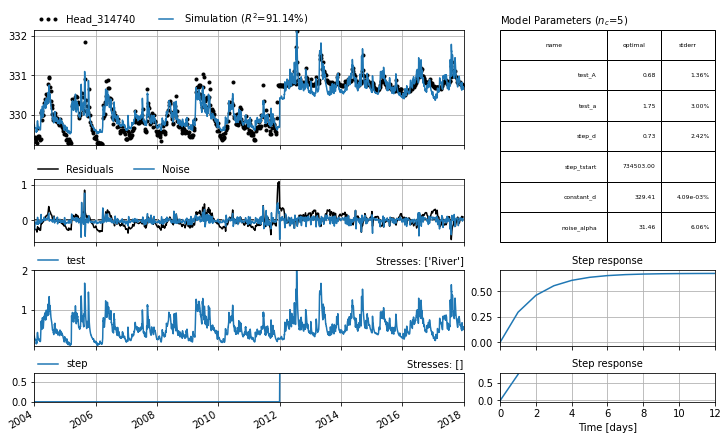

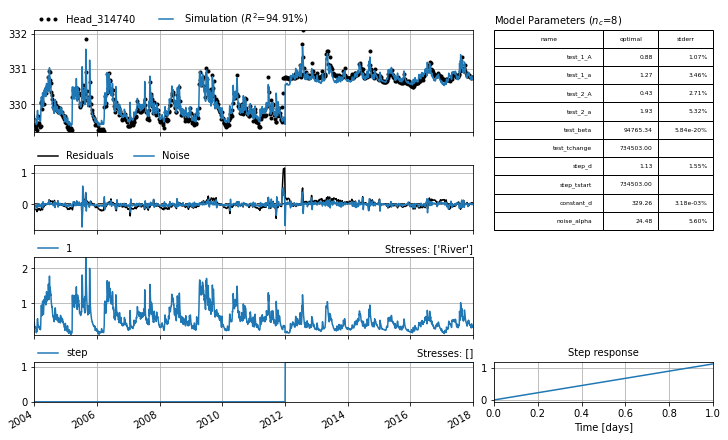

In [13]:

# Normal Model
ml = ps.Model(head, name="linear")

sm = ps.StressModel(river, ps.Exponential, name="test", settings="level")
step = ps.StepModel("2012-01-01", rfunc=ps.One, name="step")

ml.add_stressmodel([sm, step])
ml.solve(report=False, tmin="2004", tmax="2018", noise=True)
ml.plots.results(figsize=(10, 6))

# ChangeModel
ml2 = ps.Model(head, name="linear")

cm = ps.ChangeModel(river, ps.Exponential, ps.Exponential, name="test",
                    tchange="2012-01-01", settings="level")

ml2.add_stressmodel([cm, step])
ml2.solve(report=False, tmin="2004", tmax="2018", noise=True)
ml2.plots.results(figsize=(10, 6))


The second model shows a better fit, but also the step trend changed.  

In [14]:
print("RMSE for the first model:", ml.stats.rmse().round(2))
print("RMSE for the second model:", ml2.stats.rmse().round(2))

RMSE for the first model: 0.17
RMSE for the second model: 0.13


/home/david/Github/pastas/pastas/stressmodels.py:1460: RuntimeWarning: overflow encountered in exp
  omega = 1 / (np.exp(beta * (t - sigma)) + 1)


In [15]:
ml2.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
test_1_A,1.00000,test,0.881949,1.000000e-05,100.0,True,9.400239e-03
test_1_a,10.00000,test,1.272089,1.000000e-02,1000.0,True,4.395108e-02
test_2_A,1.00000,test,0.428231,1.000000e-05,100.0,True,1.161802e-02
test_2_a,10.00000,test,1.930623,1.000000e-02,1000.0,True,1.026587e-01
test_beta,0.00000,test,94765.341741,-inf,inf,True,5.536942e-17
test_tchange,734503.00000,test,734503.000000,6.124110e+05,825914.0,False,NaN
step_d,1.00000,step,1.130024,0.000000e+00,NaN,True,1.750599e-02
step_tstart,734503.00000,step,734503.000000,6.124110e+05,825914.0,False,NaN
constant_d,330.18797,constant,329.256815,NaN,NaN,True,1.046841e-02
noise_alpha,7.00000,noise,24.476206,1.000000e-05,5000.0,True,1.370047e+00


## 4. Compare the response functions
We can also look at the response to the river before and after, 

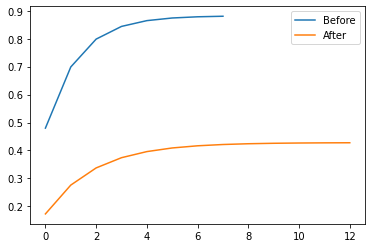

In [16]:
plt.plot(cm.rfunc1.step(p=ml2.parameters.loc[["test_1_A", "test_1_a"], "optimal"].values))
plt.plot(cm.rfunc2.step(p=ml2.parameters.loc[["test_2_A", "test_2_a"], "optimal"].values))

plt.legend(["Before", "After"])

## 5. Another way
We can also add the stress twice, saving one parameter that needs to be estimated.

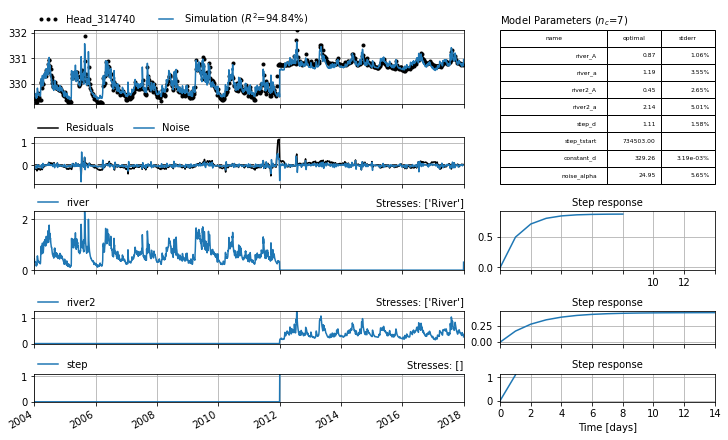

In [17]:
ml3 = ps.Model(head, name="linear")

river1 = river.copy()
river1.loc["2012":] = 0

river2 = river.copy()
river2.loc[:"2011"] = 0

r1 = ps.StressModel(river1, rfunc=ps.Exponential, name="river", settings="level")
r2 = ps.StressModel(river2, rfunc=ps.Exponential, name="river2", settings="level")
step = ps.StepModel("2012-01-01", rfunc=ps.One, name="step")

ml3.add_stressmodel([r1, r2, step])
ml3.solve(report=False, tmin="2004", tmax="2018", noise=True)
ml3.plots.results(figsize=(10,6));

## How do the results compare?

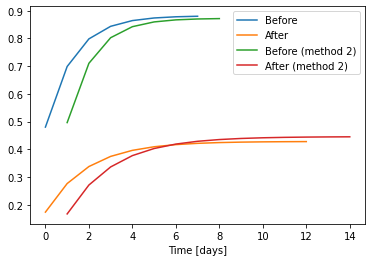

In [18]:
plt.plot(cm.rfunc1.step(p=ml2.parameters.loc[["test_1_A", "test_1_a"], "optimal"].values))
plt.plot(cm.rfunc2.step(p=ml2.parameters.loc[["test_2_A", "test_2_a"], "optimal"].values))

ml3.get_step_response("river").plot()
ml3.get_step_response("river2").plot()

plt.legend(["Before", "After", "Before (method 2)", "After (method 2)"])

## References

Obergfell, C., Bakker, M. and Maas, K. (2019), Identification and Explanation of a Change in the Groundwater Regime using Time Series Analysis. Groundwater, 57: 886-894. https://doi.org/10.1111/gwat.12891